In [17]:
zip_address='../data/landing/SA2_2021_AUST_SHP_GDA2020.zip'
target_address='../data/landing/shape_info'

import zipfile
with zipfile.ZipFile(zip_address,"r") as zip_ref:
    zip_ref.extractall(target_address)

In [18]:
import geopandas as gpd

# Reading the shapefile (geopandas automatically reads .shp, .dbf, .shx, .prj, and any related files)
gdf_shapefile = gpd.read_file("../data/landing/shape_info")


In [19]:
from pyspark.sql import SparkSession

spark = (
    SparkSession.builder.appName("project2 preprocessing")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "4g")
    .config("spark.executor.memory", "8g")
    .getOrCreate()
)

income_address=f"../data/raw/income.csv"
population_address='../data/raw/population.csv'

df_income=spark.read.csv(income_address, header=True)
df_population=spark.read.csv(population_address, header=True)

In [20]:
df_income = df_income.withColumnRenamed('SA2 code', 'SA2_CODE21')
df_population = df_population.withColumnRenamed('SA2 code', 'SA2_CODE21')

df_income_pandas = df_income.toPandas()
df_population_pandas = df_population.toPandas()

income_gdf = df_income_pandas.merge(gdf_shapefile, on='SA2_CODE21')
population_gdf = df_population_pandas.merge(gdf_shapefile, on='SA2_CODE21')

income_gdf = gpd.GeoDataFrame(income_gdf, geometry='geometry')
population_gdf = gpd.GeoDataFrame(population_gdf, geometry='geometry')

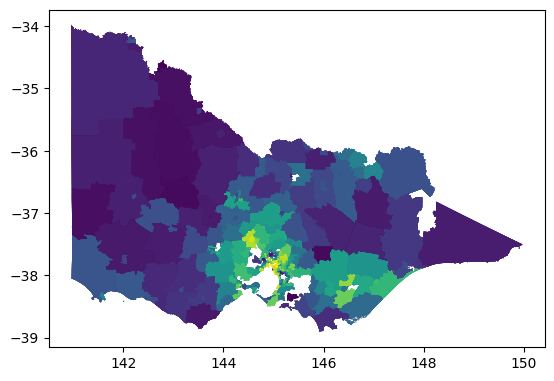

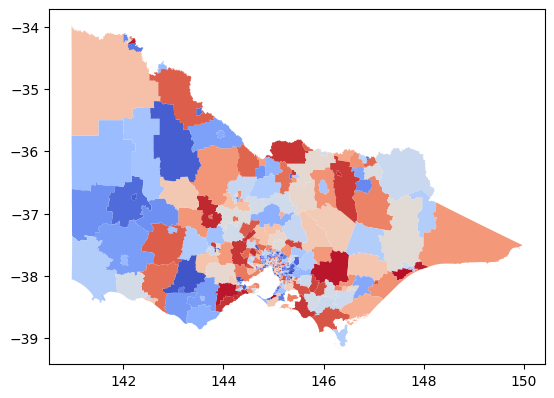

In [21]:
import matplotlib.pyplot as plt

ax=income_gdf.plot(column='estimates_personal_income_year_ended_30_june_mean_employee', cmap='viridis')

plt.savefig("../plots/income_heatmap.png", dpi=300)

ax=population_gdf.plot(column='Net population change', cmap='coolwarm')

plt.savefig("../plots/population_heatmap.png", dpi=300)
